In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 10 19:59:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   8460MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
import os
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import logging

In [64]:
#logging 

# create run_lof folder if not exist
if not os.path.exists('/content/drive/MyDrive/DLCV_CW3/run_logs/'):
    os.mkdir('/content/drive/MyDrive/DLCV_CW3/run_logs/')


Log_Format = "%(levelname)s %(asctime)s - %(message)s"

logging.basicConfig(filename = "/content/drive/MyDrive/DLCV_CW3/run_logs/resnet_"+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+".log",
                    filemode = "w",
                    format = Log_Format, 
                    level = logging.ERROR)


logger = logging.getLogger()

logger.setLevel(logging.INFO)

# Load and normalize MNIST

In [65]:
logger.info("Loading MNIST dataset") 

mnist_data_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_data/'
mnist_save_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_RESNET_results/'
mnist_fig_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_RESNET_figures/'

# create folder if not exist
if not os.path.exists(mnist_save_dir):
    os.mkdir(mnist_save_dir)

if not os.path.exists(mnist_fig_dir):
    os.mkdir(mnist_fig_dir)

In [66]:
logger.info("Transforming MNIST dataset") 

mnist_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_train_data = datasets.MNIST(root=mnist_data_dir, train=True, transform=mnist_transform, download=True)

val_size = int(len(mnist_train_data) * 0.2)
train_size = len(mnist_train_data) - val_size

mnist_train_data, mnist_val_data = random_split(mnist_train_data, [train_size, val_size])
mnist_train_loader = DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

mnist_val_loader = DataLoader(dataset=mnist_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

mnist_test_data = datasets.MNIST(root=mnist_data_dir, train=False, transform=mnist_transform, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/DLCV_CW3/MNIST_data/MNIST/raw



# Visualising the MNIST data 

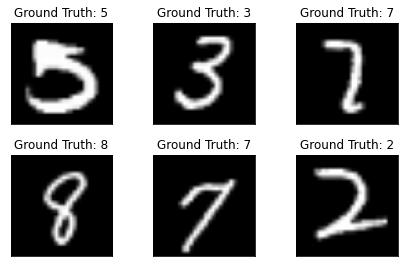

In [67]:
logger.info("Visualising MNIST dataset") 

examples = enumerate(mnist_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


# Load and normalize CIFAR10


In [68]:
logger.info("Loading Cifar dataset") 

cifar_data_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_data/'
cifar_save_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_RESNET_results/'
cifar_fig_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_RESNET_figures/'

# create folder if not exist
if not os.path.exists(cifar_save_dir):
    os.mkdir(cifar_save_dir)

if not os.path.exists(cifar_fig_dir):
    os.mkdir(cifar_fig_dir)

In [69]:
logger.info("Transforming CIFAR dataset") 

cifar_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


cifar_train_data = datasets.CIFAR10(root=cifar_data_dir, train=True, transform=cifar_transform, download=True)

val_size = int(len(cifar_train_data) * 0.2)
train_size = len(cifar_train_data) - val_size

cifar_train_data, cifar_val_data = random_split(cifar_train_data, [train_size, val_size])
cifar_train_loader = DataLoader(dataset = cifar_train_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_val_loader = DataLoader(dataset = cifar_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_test_data = datasets.CIFAR10(root=cifar_data_dir, train=False, transform=cifar_transform)
cifar_test_loader = DataLoader(dataset = cifar_test_data, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)

cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/DLCV_CW3/CIFAR10_data/cifar-10-python.tar.gz to /content/drive/MyDrive/DLCV_CW3/CIFAR10_data/


# Visualising the CIFAR data 

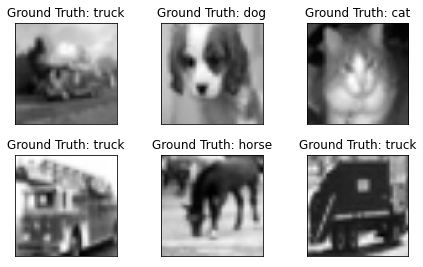

In [70]:
logger.info("Visualising CIFAR dataset") 

examples = enumerate(cifar_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(cifar_classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])


# Resnet50 Model Class

In [71]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


        
        
class ResNet50(nn.Module):
    def __init__(self, num_channels=3, num_classes = 10, ResBlock = Bottleneck):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, 3, planes=64)
        self.layer2 = self._make_layer(ResBlock, 4, planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, 6, planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, 3, planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)


In [72]:
model = ResNet50(num_channels = 3, num_classes = 10)
print(model)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05,

# Model Training Base Code 

In [73]:
def train_model(model, model_log_path, train_loader, val_loader, loss_function, optimizer):
    
    writer = SummaryWriter(model_log_path)

    
    epochs = 10

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  
    model = model.to(device)


    # tracking variables
    train_hist = {}
    train_hist['model_train_losses'] = []
    train_hist['model_val_losses'] = []
    train_hist['model_val_accuracies'] = []
    train_hist['model_per_epoch_ptimes'] = []
    train_hist['model_total_ptime'] = []


    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        loss_train = []    
        epoch_start_time = time.time()
        for (image, target) in tqdm(train_loader):
            image = image.to(device)

            target = target.to(device)

            ## Forward Pass
            model_optimizer.zero_grad()
            scores = model(image)
            loss = loss_function(scores,target.to(device))
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())

        val_accuracy = 0
        val_loss = []
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for (image, target) in tqdm(val_loader):
                image = image.to(device)

                target = target.to(device)
                
                scores = model(image)
                loss = loss_function(scores,target.to(device)).item()
                _, predictions = scores.max(1)
                num_correct += (predictions == target.to(device)).sum()
                num_samples += predictions.size(0)
                val_loss.append(loss)
            val_accuracy = float(num_correct) / float(num_samples)

        epoch_loss_train = np.mean(loss_train)
        epoch_val_loss = np.mean(val_loss)
        epoch_val_accuracy = val_accuracy
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Training loss: %.8f, Validation loss: %.8f, Validation Accuracies: %.8f " % (epoch_loss_train, epoch_val_loss, epoch_val_accuracy))

        # record the loss for every epoch
        train_hist['model_train_losses'].append(epoch_loss_train)
        train_hist['model_val_losses'].append(epoch_val_loss)
        train_hist['model_val_accuracies'].append(epoch_val_accuracy)
        train_hist['model_per_epoch_ptimes'].append(per_epoch_ptime)
        
        writer.add_scalar("Loss/train", epoch_loss_train, epoch)
        writer.add_scalar("Loss/Val", epoch_val_loss, epoch)
        writer.add_scalar("Accuracy/val", epoch_val_accuracy, epoch)


    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['model_total_ptime'].append(total_ptime)
    
    writer.flush()
    
    writer.close()

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['model_per_epoch_ptimes']), epochs, total_ptime))
    
    
    return model, train_hist

In [74]:
def test_model(model, test_loader, loss_function):
    
    num_correct = 0
    num_samples = 0

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  

    test_loss = []

    for (image, target) in tqdm(test_loader):
        image = image.to(device)

        target = target.to(device)
        
        scores = model(image)

        loss = loss_function(scores,target).item()

        _, predictions = scores.max(1)
        num_correct += (predictions == target).sum()
        num_samples += predictions.size(0)

        test_loss.append(loss)

    test_accuracy = float(num_correct) / float(num_samples)
    avg_test_loss = np.mean(test_loss)

    print("Testing loss: %.8f, Testing Accuracies: %.8f " % (avg_test_loss, test_accuracy))

    return test_loss


# Training MNSIT dataset on RESNET50

10-05-2022-19-59-32
Training RESNET on mnist with lr=0.0001 optimizer= Adam


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 1 of 10 with 607.32 s
Training loss: 0.16781250, Validation loss: 0.04740578, Validation Accuracies: 0.98508333 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 2 of 10 with 619.42 s
Training loss: 0.04406341, Validation loss: 0.04949137, Validation Accuracies: 0.98433333 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 3 of 10 with 619.57 s
Training loss: 0.03438027, Validation loss: 0.03576068, Validation Accuracies: 0.98900000 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 4 of 10 with 619.42 s
Training loss: 0.02899130, Validation loss: 0.03756299, Validation Accuracies: 0.98841667 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 5 of 10 with 619.38 s
Training loss: 0.02667135, Validation loss: 0.04275841, Validation Accuracies: 0.98641667 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 6 of 10 with 619.22 s
Training loss: 0.02261578, Validation loss: 0.03643723, Validation Accuracies: 0.98983333 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 7 of 10 with 619.17 s
Training loss: 0.01998301, Validation loss: 0.03330546, Validation Accuracies: 0.98925000 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 8 of 10 with 619.45 s
Training loss: 0.01932636, Validation loss: 0.02883688, Validation Accuracies: 0.99166667 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 9 of 10 with 619.38 s
Training loss: 0.01754692, Validation loss: 0.03165472, Validation Accuracies: 0.99033333 


100%|██████████| 188/188 [00:43<00:00,  4.30it/s]


Epoch 10 of 10 with 619.37 s
Training loss: 0.01659032, Validation loss: 0.03618253, Validation Accuracies: 0.98816667 
Avg per epoch ptime: 618.17, total 10 epochs ptime: 6181.73
Training finish!... save and plotting training results


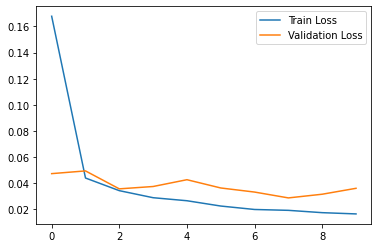

Testing RESNET trained model


100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


Testing loss: 0.03265934, Testing Accuracies: 0.98910000 
Testing finish!... plotting testing results


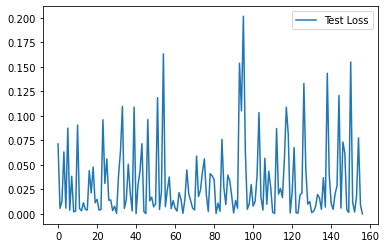

Training RESNET on mnist with lr=0.0001 optimizer= SGD


100%|██████████| 188/188 [00:43<00:00,  4.30it/s]


Epoch 1 of 10 with 613.89 s
Training loss: 2.15405739, Validation loss: 2.00862503, Validation Accuracies: 0.31508333 


100%|██████████| 188/188 [00:43<00:00,  4.29it/s]


Epoch 2 of 10 with 614.21 s
Training loss: 1.91055571, Validation loss: 1.82466610, Validation Accuracies: 0.39483333 


100%|██████████| 188/188 [00:43<00:00,  4.29it/s]


Epoch 3 of 10 with 613.92 s
Training loss: 1.76833978, Validation loss: 1.70471085, Validation Accuracies: 0.50358333 


100%|██████████| 188/188 [00:43<00:00,  4.29it/s]


Epoch 4 of 10 with 614.31 s
Training loss: 1.66077388, Validation loss: 1.59927777, Validation Accuracies: 0.56791667 


100%|██████████| 188/188 [00:43<00:00,  4.30it/s]


Epoch 5 of 10 with 614.33 s
Training loss: 1.54998746, Validation loss: 1.49306109, Validation Accuracies: 0.62650000 


100%|██████████| 188/188 [00:43<00:00,  4.30it/s]


Epoch 6 of 10 with 614.13 s
Training loss: 1.43571775, Validation loss: 1.36987995, Validation Accuracies: 0.66558333 


100%|██████████| 188/188 [00:43<00:00,  4.30it/s]


Epoch 7 of 10 with 614.47 s
Training loss: 1.31428536, Validation loss: 1.25086862, Validation Accuracies: 0.69600000 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 8 of 10 with 614.50 s
Training loss: 1.18895708, Validation loss: 1.12435415, Validation Accuracies: 0.72341667 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 9 of 10 with 613.61 s
Training loss: 1.06405918, Validation loss: 1.00193408, Validation Accuracies: 0.75325000 


100%|██████████| 188/188 [00:43<00:00,  4.30it/s]


Epoch 10 of 10 with 613.75 s
Training loss: 0.94782285, Validation loss: 0.90070333, Validation Accuracies: 0.77608333 
Avg per epoch ptime: 614.11, total 10 epochs ptime: 6141.13
Training finish!... save and plotting training results


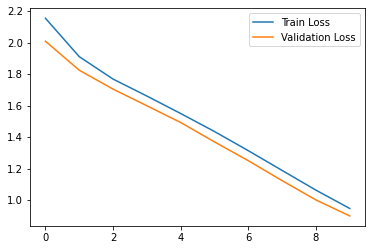

Testing RESNET trained model


100%|██████████| 157/157 [00:36<00:00,  4.30it/s]


Testing loss: 0.88077605, Testing Accuracies: 0.78810000 
Testing finish!... plotting testing results


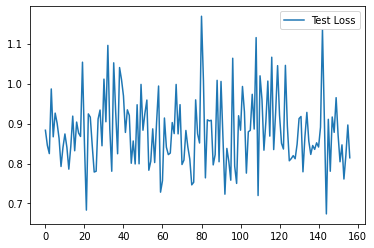

Training RESNET on mnist with lr=0.01 optimizer= Adam


100%|██████████| 188/188 [00:43<00:00,  4.33it/s]


Epoch 1 of 10 with 617.50 s
Training loss: 0.78408802, Validation loss: 0.13848229, Validation Accuracies: 0.95891667 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 2 of 10 with 616.96 s
Training loss: 0.10176251, Validation loss: 0.07248883, Validation Accuracies: 0.97675000 


100%|██████████| 188/188 [00:43<00:00,  4.33it/s]


Epoch 3 of 10 with 617.13 s
Training loss: 0.07091369, Validation loss: 0.08127519, Validation Accuracies: 0.97416667 


100%|██████████| 188/188 [00:43<00:00,  4.34it/s]


Epoch 4 of 10 with 616.77 s
Training loss: 0.06034102, Validation loss: 0.07337824, Validation Accuracies: 0.97758333 


100%|██████████| 188/188 [00:43<00:00,  4.35it/s]


Epoch 5 of 10 with 616.97 s
Training loss: 0.05150448, Validation loss: 0.05274566, Validation Accuracies: 0.98425000 


100%|██████████| 188/188 [00:43<00:00,  4.35it/s]


Epoch 6 of 10 with 615.87 s
Training loss: 0.04644432, Validation loss: 0.03785363, Validation Accuracies: 0.98850000 


100%|██████████| 188/188 [00:43<00:00,  4.34it/s]


Epoch 7 of 10 with 616.23 s
Training loss: 0.03924925, Validation loss: 0.04337469, Validation Accuracies: 0.98716667 


100%|██████████| 188/188 [00:43<00:00,  4.35it/s]


Epoch 8 of 10 with 615.61 s
Training loss: 0.03976909, Validation loss: 0.04642053, Validation Accuracies: 0.98483333 


100%|██████████| 188/188 [00:43<00:00,  4.35it/s]


Epoch 9 of 10 with 615.32 s
Training loss: 0.03345872, Validation loss: 0.04530728, Validation Accuracies: 0.98733333 


100%|██████████| 188/188 [00:43<00:00,  4.35it/s]


Epoch 10 of 10 with 615.00 s
Training loss: 0.03180659, Validation loss: 0.03981790, Validation Accuracies: 0.98800000 
Avg per epoch ptime: 616.33, total 10 epochs ptime: 6163.36
Training finish!... save and plotting training results


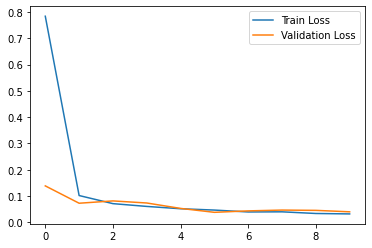

Testing RESNET trained model


100%|██████████| 157/157 [00:36<00:00,  4.33it/s]


Testing loss: 0.03712151, Testing Accuracies: 0.98870000 
Testing finish!... plotting testing results


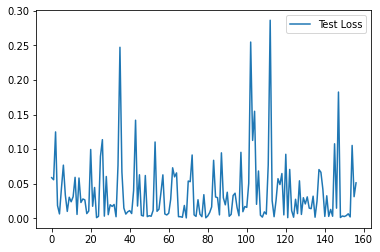

Training RESNET on mnist with lr=0.01 optimizer= SGD


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 1 of 10 with 612.67 s
Training loss: 0.39567783, Validation loss: 0.06157331, Validation Accuracies: 0.98125000 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 2 of 10 with 612.84 s
Training loss: 0.04931228, Validation loss: 0.04210052, Validation Accuracies: 0.98741667 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 3 of 10 with 612.60 s
Training loss: 0.02770882, Validation loss: 0.03744460, Validation Accuracies: 0.98800000 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 4 of 10 with 612.60 s
Training loss: 0.01684348, Validation loss: 0.02964082, Validation Accuracies: 0.99075000 


100%|██████████| 188/188 [00:43<00:00,  4.33it/s]


Epoch 5 of 10 with 612.12 s
Training loss: 0.00996039, Validation loss: 0.02949477, Validation Accuracies: 0.99158333 


100%|██████████| 188/188 [00:43<00:00,  4.33it/s]


Epoch 6 of 10 with 612.32 s
Training loss: 0.00532458, Validation loss: 0.02625942, Validation Accuracies: 0.99258333 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 7 of 10 with 613.21 s
Training loss: 0.00247201, Validation loss: 0.02512486, Validation Accuracies: 0.99308333 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 8 of 10 with 613.14 s
Training loss: 0.00181085, Validation loss: 0.02490038, Validation Accuracies: 0.99366667 


100%|██████████| 188/188 [00:43<00:00,  4.31it/s]


Epoch 9 of 10 with 613.79 s
Training loss: 0.00154949, Validation loss: 0.02426897, Validation Accuracies: 0.99291667 


100%|██████████| 188/188 [00:43<00:00,  4.32it/s]


Epoch 10 of 10 with 613.71 s
Training loss: 0.00114239, Validation loss: 0.02469953, Validation Accuracies: 0.99258333 
Avg per epoch ptime: 612.90, total 10 epochs ptime: 6129.02
Training finish!... save and plotting training results


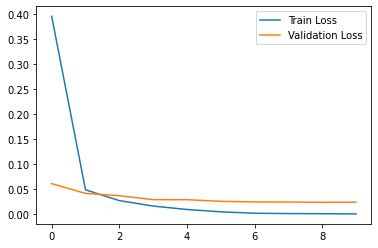

Testing RESNET trained model


100%|██████████| 157/157 [00:36<00:00,  4.30it/s]


Testing loss: 0.02555749, Testing Accuracies: 0.99180000 
Testing finish!... plotting testing results


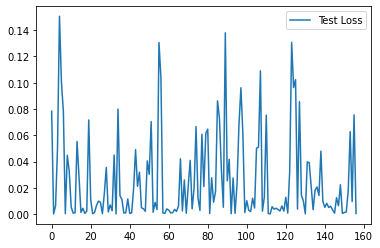

In [75]:
logger.info("Training resnet on MNIST dataset") 
print(datetime.today().strftime('%d-%m-%Y-%H-%M-%S'))

for lr in [0.0001, 0.01]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/resnet_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
            print("Already trained on RESNET on mnist with lr={} optimizer= {}".format(lr,optimizer))
  

        else:
            model = ResNet50(num_channels = 3, num_classes = 10)
            #model.eval()

            if optimizer == 'Adam':
                model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if optimizer == 'SGD':
                model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            print("Training RESNET on mnist with lr={} optimizer= {}".format(lr,optimizer))
          
            model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/mnist_resnet_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

            trained_model, train_hist = train_model(model, model_log_path, mnist_train_loader, mnist_val_loader, criterion, model_optimizer)
            
            print("Training finish!... save and plotting training results")

            with open(mnist_save_dir +'train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
                pickle.dump(train_hist, f)

            logger.info("Saving RESNET trained model on  MNIST dataset") 
            torch.save(model.state_dict(), mnist_save_dir+"/resnet_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

            logger.info("Plotting RESNET Model train losses on MNIST") 

            plt.plot(train_hist['model_train_losses'])
            plt.plot(train_hist['model_val_losses'])
            plt.legend(["Train Loss", "Validation Loss"])
            plt.savefig(mnist_fig_dir + "/resnet_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()    

            print("Testing RESNET trained model")
            test_loss = test_model(model, mnist_test_loader, criterion)
            print("Testing finish!... plotting testing results")
            plt.plot(test_loss)
            plt.legend(["Test Loss"])
            plt.savefig(mnist_fig_dir + "/resnet_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()
        print("========================================================")



# Training CIFAR 10 dataset on VGG

11-05-2022-02-52-17
Training RESNET on cifar10 with lr=0.0001 optimizer= Adam


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 1 of 10 with 517.87 s
Training loss: 1.50616633, Validation loss: 1.15326792, Validation Accuracies: 0.59260000 


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 2 of 10 with 518.25 s
Training loss: 0.99776013, Validation loss: 0.87838070, Validation Accuracies: 0.69200000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 3 of 10 with 518.24 s
Training loss: 0.75826067, Validation loss: 0.74649096, Validation Accuracies: 0.74420000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 4 of 10 with 518.38 s
Training loss: 0.60367121, Validation loss: 0.69230495, Validation Accuracies: 0.76490000 


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 5 of 10 with 518.33 s
Training loss: 0.47381092, Validation loss: 0.63691125, Validation Accuracies: 0.78720000 


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 6 of 10 with 518.21 s
Training loss: 0.35837586, Validation loss: 0.64029873, Validation Accuracies: 0.79720000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 7 of 10 with 518.45 s
Training loss: 0.26454028, Validation loss: 0.66407489, Validation Accuracies: 0.79060000 


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 8 of 10 with 518.52 s
Training loss: 0.18394851, Validation loss: 0.69152404, Validation Accuracies: 0.79430000 


100%|██████████| 157/157 [00:36<00:00,  4.25it/s]


Epoch 9 of 10 with 518.27 s
Training loss: 0.14371479, Validation loss: 0.77563189, Validation Accuracies: 0.79040000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 10 of 10 with 518.49 s
Training loss: 0.11850316, Validation loss: 0.80279078, Validation Accuracies: 0.79240000 
Avg per epoch ptime: 518.30, total 10 epochs ptime: 5183.03
Training finish!... save and plotting training results


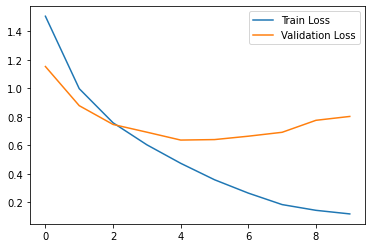

Testing VGG trained model


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Testing loss: 0.80481569, Testing Accuracies: 0.79090000 
Testing finish!... plotting testing results


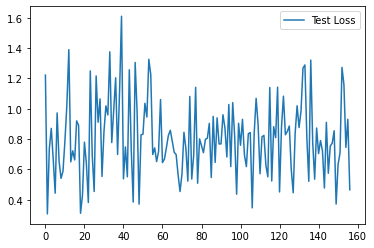

Training RESNET on cifar10 with lr=0.0001 optimizer= SGD


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 1 of 10 with 513.06 s
Training loss: 2.28180889, Validation loss: 2.25017387, Validation Accuracies: 0.15460000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 2 of 10 with 513.12 s
Training loss: 2.23204440, Validation loss: 2.22784694, Validation Accuracies: 0.16780000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 3 of 10 with 513.05 s
Training loss: 2.21536777, Validation loss: 2.21457704, Validation Accuracies: 0.17100000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 4 of 10 with 513.30 s
Training loss: 2.19128660, Validation loss: 2.18753791, Validation Accuracies: 0.18880000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 5 of 10 with 512.52 s
Training loss: 2.16816501, Validation loss: 2.16951594, Validation Accuracies: 0.19220000 


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 6 of 10 with 512.80 s
Training loss: 2.13899832, Validation loss: 2.12986528, Validation Accuracies: 0.21720000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 7 of 10 with 513.11 s
Training loss: 2.09811667, Validation loss: 2.08661037, Validation Accuracies: 0.23100000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 8 of 10 with 512.98 s
Training loss: 2.05607782, Validation loss: 2.04694674, Validation Accuracies: 0.25200000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 9 of 10 with 512.98 s
Training loss: 2.01768886, Validation loss: 2.00783889, Validation Accuracies: 0.26370000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 10 of 10 with 512.25 s
Training loss: 1.98247647, Validation loss: 1.98128941, Validation Accuracies: 0.27550000 
Avg per epoch ptime: 512.92, total 10 epochs ptime: 5129.18
Training finish!... save and plotting training results


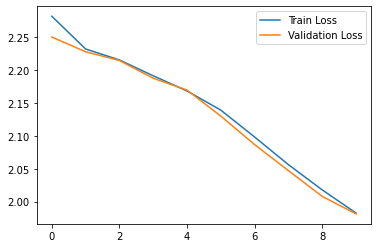

Testing VGG trained model


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Testing loss: 1.96601792, Testing Accuracies: 0.28380000 
Testing finish!... plotting testing results


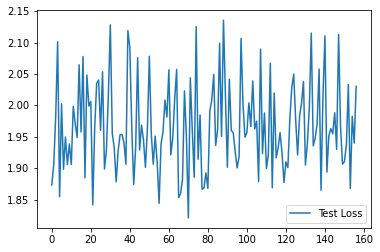

Training RESNET on cifar10 with lr=0.01 optimizer= Adam


100%|██████████| 157/157 [00:36<00:00,  4.30it/s]


Epoch 1 of 10 with 514.98 s
Training loss: 2.11834451, Validation loss: 1.71032283, Validation Accuracies: 0.35880000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 2 of 10 with 516.04 s
Training loss: 1.43558076, Validation loss: 1.19882146, Validation Accuracies: 0.57380000 


100%|██████████| 157/157 [00:36<00:00,  4.29it/s]


Epoch 3 of 10 with 515.69 s
Training loss: 1.15523094, Validation loss: 1.08171009, Validation Accuracies: 0.61910000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 4 of 10 with 515.83 s
Training loss: 0.99305634, Validation loss: 0.95485021, Validation Accuracies: 0.66370000 


100%|██████████| 157/157 [00:36<00:00,  4.30it/s]


Epoch 5 of 10 with 515.86 s
Training loss: 0.87543139, Validation loss: 0.83213762, Validation Accuracies: 0.71000000 


100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


Epoch 6 of 10 with 515.02 s
Training loss: 0.75679612, Validation loss: 0.75904727, Validation Accuracies: 0.74500000 


100%|██████████| 157/157 [00:36<00:00,  4.29it/s]


Epoch 7 of 10 with 514.73 s
Training loss: 0.65711885, Validation loss: 0.69148557, Validation Accuracies: 0.77080000 


100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


Epoch 8 of 10 with 514.62 s
Training loss: 0.57671668, Validation loss: 0.68603291, Validation Accuracies: 0.76380000 


100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


Epoch 9 of 10 with 514.35 s
Training loss: 0.49504110, Validation loss: 0.65091487, Validation Accuracies: 0.78480000 


100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


Epoch 10 of 10 with 513.50 s
Training loss: 0.42467240, Validation loss: 0.66259331, Validation Accuracies: 0.77820000 
Avg per epoch ptime: 515.06, total 10 epochs ptime: 5150.62
Training finish!... save and plotting training results


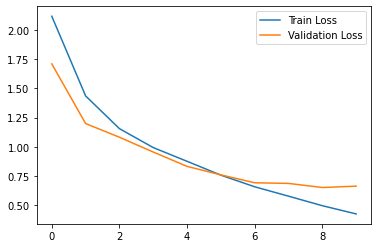

Testing VGG trained model


100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


Testing loss: 0.69030501, Testing Accuracies: 0.77010000 
Testing finish!... plotting testing results


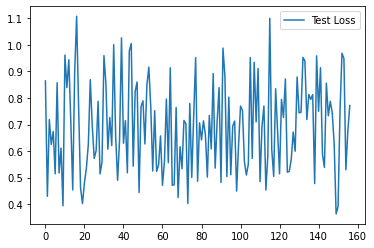

Training RESNET on cifar10 with lr=0.01 optimizer= SGD


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 1 of 10 with 512.97 s
Training loss: 1.95585133, Validation loss: 1.67800145, Validation Accuracies: 0.40050000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 2 of 10 with 512.23 s
Training loss: 1.44494932, Validation loss: 1.33083515, Validation Accuracies: 0.54030000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 3 of 10 with 512.53 s
Training loss: 1.16465236, Validation loss: 1.10480593, Validation Accuracies: 0.60940000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 4 of 10 with 512.44 s
Training loss: 0.95708825, Validation loss: 0.95267709, Validation Accuracies: 0.66580000 


100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


Epoch 5 of 10 with 512.88 s
Training loss: 0.78460047, Validation loss: 0.86255453, Validation Accuracies: 0.69850000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 6 of 10 with 513.31 s
Training loss: 0.63573941, Validation loss: 0.81706440, Validation Accuracies: 0.71920000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 7 of 10 with 512.77 s
Training loss: 0.49421736, Validation loss: 0.76649688, Validation Accuracies: 0.74260000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 8 of 10 with 512.65 s
Training loss: 0.37179836, Validation loss: 0.77941391, Validation Accuracies: 0.75420000 


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Epoch 9 of 10 with 512.57 s
Training loss: 0.27315083, Validation loss: 0.81754181, Validation Accuracies: 0.75560000 


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 10 of 10 with 512.46 s
Training loss: 0.20111352, Validation loss: 0.91567619, Validation Accuracies: 0.74710000 
Avg per epoch ptime: 512.68, total 10 epochs ptime: 5126.83
Training finish!... save and plotting training results


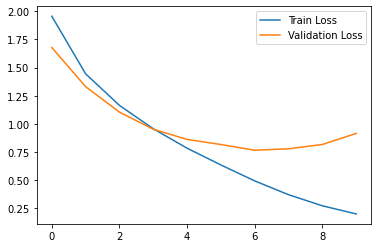

Testing VGG trained model


100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


Testing loss: 0.95669156, Testing Accuracies: 0.74360000 
Testing finish!... plotting testing results


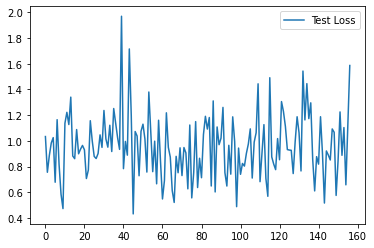

In [76]:
logger.info("Trianing RESNET on CIFAR dataset") 
print(datetime.today().strftime('%d-%m-%Y-%H-%M-%S'))

for lr in [0.0001, 0.01]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/resnet_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
            print("Already trained RESNET on cifar with lr={} optimizer= {}".format(lr,optimizer))
  

        else:
            model = ResNet50(num_channels = 3, num_classes = 10)
            #model.eval()

            if optimizer == 'Adam':
                model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if optimizer == 'SGD':
                model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          
            print("Training RESNET on cifar10 with lr={} optimizer= {}".format(lr,optimizer))
          
            model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/cifar_resnet_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

            trained_model, train_hist = train_model(model, model_log_path, cifar_train_loader, cifar_val_loader, criterion, model_optimizer)
            
            print("Training finish!... save and plotting training results")

            with open(cifar_save_dir +'resnet_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
                pickle.dump(train_hist, f)

            logger.info("Saving RESNET trained model on CIFAR dataset") 
            torch.save(model.state_dict(), cifar_save_dir+"/resnet_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

            logger.info("Plotting RESNET Model train losses on CIFAR") 

            plt.plot(train_hist['model_train_losses'])
            plt.plot(train_hist['model_val_losses'])
            plt.legend(["Train Loss", "Validation Loss"])
            plt.savefig(cifar_fig_dir + "/resnet_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()

            print("Testing VGG trained model")
            test_loss = test_model(model, cifar_test_loader, criterion)
            print("Testing finish!... plotting testing results")
            plt.plot(test_loss)
            plt.legend(["Test Loss"])
            plt.savefig(cifar_fig_dir + "/resnet_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()
        print("========================================================")
